# Exploratory Analysis of Air Quality Data for Ulaanbaatar, Mongolia

In this project, I analyze air quality data from the U.S. Embassy in Ulaanbaatar, Mongolia, collected between 2017 and 2020. Ulaanbaatar is recognized as one of the most polluted cities in the world. The main source of pollution is the burning of coal in domestic stoves during cold seasons, especially in the winter, when temperatures often drop below −20 °C. 

The high levels of pollution have been linked to significant health issues, including respiratory diseases and other long-term conditions. In 2011, 29% of heart and lung disease deaths and 40% of lung cancer deaths in Ulaanbaatar were attributable to outdoor air pollution. Therefore, monitoring and analyzing key pollutants is essential for raising public awareness and driving policy changes that can meaningfully address this urgent problem.

In this exploratory analysis, I focused on three major pollutants: PM2.5, PM10, and SO2. I cover the overall descriptive statistics for each pollutant, explore the correlations between them, calculate the Air Quality Index (AQI), and identify the most polluted days, months, and general trends over time.

## Setup

### Importing necessary libraries

In [1042]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

### Loading the data

In [1045]:
df = pd.read_csv('/Users/anumunkhsaikhan/Downloads/ulaanbaatar-us embassy-air-quality.csv', index_col = 'date')

### First glance at the data

In [1048]:
print(df.head())
df.info()

          pm25 pm10 no2 so2  co
date                           
2021/11/2   13   70       5    
2021/11/3   48  101       9    
2021/11/4  162   97       9    
2021/11/5  124   60       3    
2021/11/6   45   65       8    
<class 'pandas.core.frame.DataFrame'>
Index: 2542 entries, 2021/11/2 to 2014/10/20
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   pm25    2542 non-null   object
 1   pm10    2542 non-null   object
 2   no2     2542 non-null   object
 3   so2     2542 non-null   object
 4    co     2542 non-null   object
dtypes: object(5)
memory usage: 119.2+ KB


### Cleaning the data

In [1051]:
#replacing missing values (blank) with NaN
df = df.replace(r'^\s*$', np.nan, regex=True)

#converting values to numeric
df = df.apply(pd.to_numeric)

#removing empty spaces at the beginning of column names
df.columns = df.columns.str.lstrip()

df.head()

,pm25,pm10,no2,so2,co
date,,,,,
2021/11/2,13.0,70.0,NaN,5.0,NaN
2021/11/3,48.0,101.0,NaN,9.0,NaN
2021/11/4,162.0,97.0,NaN,9.0,NaN
2021/11/5,124.0,60.0,NaN,3.0,NaN
2021/11/6,45.0,65.0,NaN,8.0,NaN


In [1053]:
#setting the index to dates and sorting by dates

df.index = pd.to_datetime(df.index, format='%Y/%m/%d')
df = df.sort_index()

#subsetting the original data to the period we're interested in: 2017/01/01 - 2020/12/31 
df = df.loc['2017-01-01':'2020-12-31']

# Creating a new date range with daily frequency from the minimum to maximum date
daily_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

# Reindexing to the new daily frequency
df = df.reindex(daily_index)

#### Missing data heat map

pm25    13.963039
pm10     3.285421
no2     43.189596
so2     22.724162
co      52.292950
dtype: float64


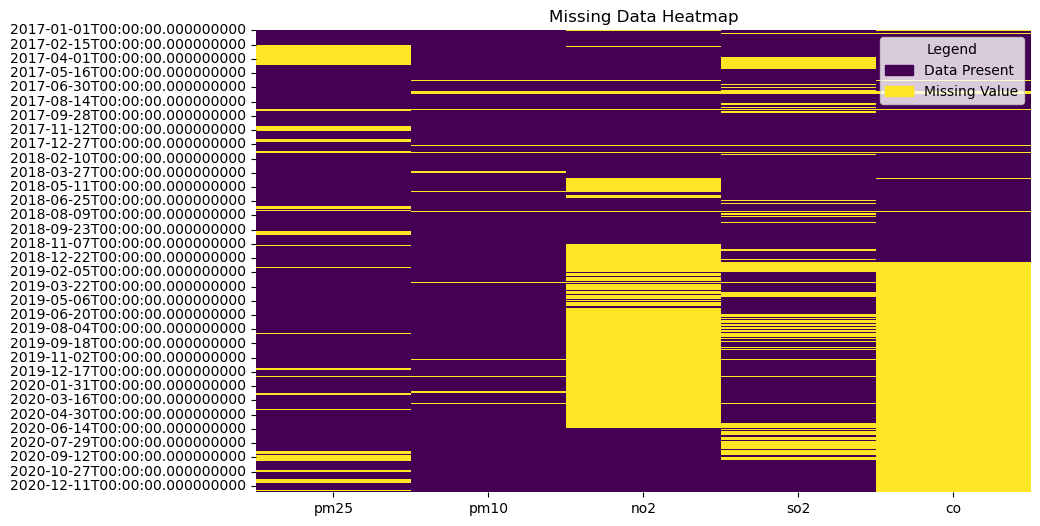

In [1060]:
# Calculating the missing data percentages for each column
missing_perc = df.isnull().mean() * 100
print(missing_perc)

# Plotting a heat map
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')

# Creating custom legend with two patches
purple_patch = mpatches.Patch(color='#440154', label='Data Present')  
yellow_patch = mpatches.Patch(color='#FDE725', label='Missing Value')  

# Adding the legend to the plot
plt.legend(handles=[purple_patch, yellow_patch], title="Legend")
plt.title("Missing Data Heatmap")
plt.show()

Approximately half of the values for the pollutants CO and NO2 were missing. Since applying imputation methods could introduce biases, I chose to drop these variables from the analysis.

In [986]:
df = df.drop(['co', 'no2'], axis = 1)

#### Interpolating for the remaining missing values

In [988]:
#using linear interpolation to replace missing data (https://ehemj.com/article-1-815-en.pdf)
df.interpolate(limit_direction="both",inplace=True)

#checking if there are any missing values after the interpolation
df.isnull().sum()

pm25    0
pm10    0
so2     0
dtype: int64

## Exploratory Analysis

### Descriptive Stats

In [991]:
# Generating descriptive stats
summary_stats = df.describe()

# Creating a table of descriptive stats
table = pd.DataFrame({
    'Mean': summary_stats.loc['mean'],
    'Standard Deviation': summary_stats.loc['std'],
    'Minimum': summary_stats.loc['min'],
    '25th Percentile': summary_stats.loc['25%'],
    'Median (50th Percentile)': summary_stats.loc['50%'],
    '75th Percentile': summary_stats.loc['75%'],
    'Maximum': summary_stats.loc['max']
}).reset_index()

# Renaming the 'index' column to 'Pollutant'
table.rename(columns={'index': 'Pollutant'}, inplace=True)

print(table)

  Pollutant        Mean  Standard Deviation  Minimum  25th Percentile  \
0      pm25  103.321355           76.213512      5.0             49.0   
1      pm10   94.888090           78.985242      6.0             55.0   
2       so2   11.762834           14.656237      1.0              2.0   

   Median (50th Percentile)  75th Percentile  Maximum  
0                      75.0            138.0    477.0  
1                      74.0            103.0    695.0  
2                       5.0             16.0     87.0  


PM2.5 and PM10 have high mean values and significant variability, indicating frequent and severe pollution episodes.
All pollutants have high maximum values, suggesting that severe pollution events are present.


### Correlation between pollutants

          pm25      pm10       so2
pm25  1.000000  0.601715  0.683975
pm10  0.601715  1.000000  0.573998
so2   0.683975  0.573998  1.000000


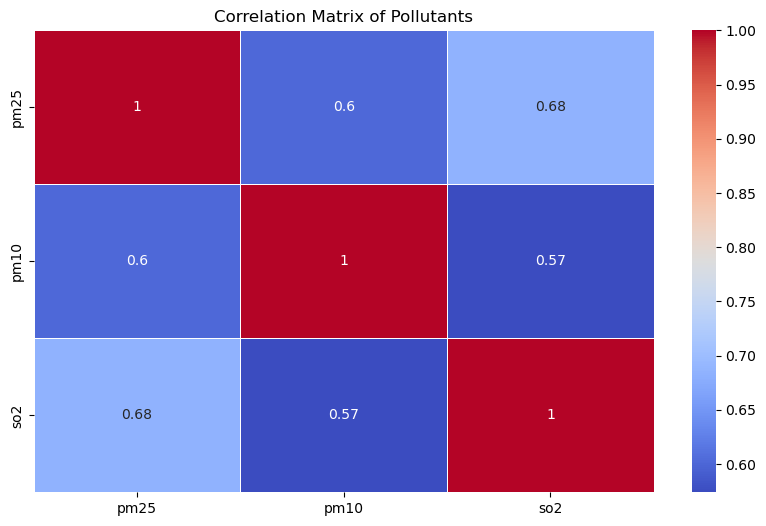

In [994]:
# Calculating the correlation matrix
correlation_matrix = df.corr()
print(correlation_matrix)

# Setting up the plot
plt.figure(figsize=(10, 6))

# Creating a mask for the upper triangle 
#mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Pollutants')
plt.show()

PM2.5 and PM10 have a moderate positive correlation (0.60). It indicates that both pollutants may have similar sources. PM2.5 and SO2 also have a moderate positive correlation (0.68), which could suggest shared sources. Understanding correlations between data sources can be valuable, especially when dealing with missing data or when the causal variables that influence pollutant concentration are unknown. 

### Calculating Air Quality Index (AQI)

In [997]:
# Function to calculate AQI based on pollutant concentration
def calculate_aqi(concentration, breakpoints):
    # Looping through the breakpoints to find the correct range
    for bp in breakpoints:
        if bp['C_lo'] <= concentration <= bp['C_hi']:
            # AQI formula 
            aqi = (bp['I_hi'] - bp['I_lo']) / (bp['C_hi'] - bp['C_lo']) * (concentration - bp['C_lo']) + bp['I_lo']
            return round(aqi)
    return None  # Return None if the concentration is outside the defined ranges

# Defining AQI breakpoints for each pollutant (all values in µg/m³)
aqi_breakpoints = {
    'pm25': [
        {'C_lo': 0.0, 'C_hi': 9.0, 'I_lo': 0, 'I_hi': 50},
        {'C_lo': 9.1, 'C_hi': 35.4, 'I_lo': 51, 'I_hi': 100},
        {'C_lo': 35.5, 'C_hi': 55.4, 'I_lo': 101, 'I_hi': 150},
        {'C_lo': 55.5, 'C_hi': 125.4, 'I_lo': 151, 'I_hi': 200},
        {'C_lo': 125.5, 'C_hi': 225.4, 'I_lo': 201, 'I_hi': 300},
        {'C_lo': 225.5, 'C_hi': 325.4, 'I_lo': 301, 'I_hi': 500}
    ],
    'pm10': [
        {'C_lo': 0, 'C_hi': 54, 'I_lo': 0, 'I_hi': 50},
        {'C_lo': 55, 'C_hi': 154, 'I_lo': 51, 'I_hi': 100},
        {'C_lo': 155, 'C_hi': 254, 'I_lo': 101, 'I_hi': 150},
        {'C_lo': 255, 'C_hi': 354, 'I_lo': 151, 'I_hi': 200},
        {'C_lo': 355, 'C_hi': 424, 'I_lo': 201, 'I_hi': 300},
        {'C_lo': 425, 'C_hi': 604, 'I_lo': 301, 'I_hi': 500},
    ],
    'so2': [
        {'C_lo': 0, 'C_hi': 35, 'I_lo': 0, 'I_hi': 50},
        {'C_lo': 36, 'C_hi': 75, 'I_lo': 51, 'I_hi': 100},
        {'C_lo': 76, 'C_hi': 185, 'I_lo': 101, 'I_hi': 150},
        {'C_lo': 186, 'C_hi': 304, 'I_lo': 151, 'I_hi': 200},
        {'C_lo': 305, 'C_hi': 604, 'I_lo': 201, 'I_hi': 300},
        {'C_lo': 605, 'C_hi': 1004, 'I_lo': 301, 'I_hi': 500},
    ]
}

# Creating a new empty data frame to store the AQI values
df_aqi = pd.DataFrame()

# Looping through each pollutant and applying AQI calculation
for pollutant, breakpoints in aqi_breakpoints.items():
    # Calculating AQI for each pollutant and storing it in df_aqi
    df_aqi[f'aqi_{pollutant}'] = df[pollutant].apply(lambda x: calculate_aqi(x, breakpoints))

# Calculating the overall AQI for each day by taking the maximum AQI of all pollutants
df_aqi['overall_aqi'] = df_aqi.max(axis=1)

print(df_aqi.head())

            aqi_pm25  aqi_pm10  aqi_so2  overall_aqi
2017-01-01     292.0      75.0      105        292.0
2017-01-02     222.0     162.0      105        222.0
2017-01-03     402.0     462.0       51        462.0
2017-01-04     338.0     230.0       81        338.0
2017-01-05     286.0     189.0       76        286.0


he AQIs are calculated using the latest updates to the breakpoints from the EPA. The daily overall AQIs are calculated by taking the highest AQI value from the individual pollutants (PM2.5, PM10, and SO2): https://document.airnow.gov/technical-assistance-document-for-the-reporting-of-daily-air-quailty.pdf

### Time Series

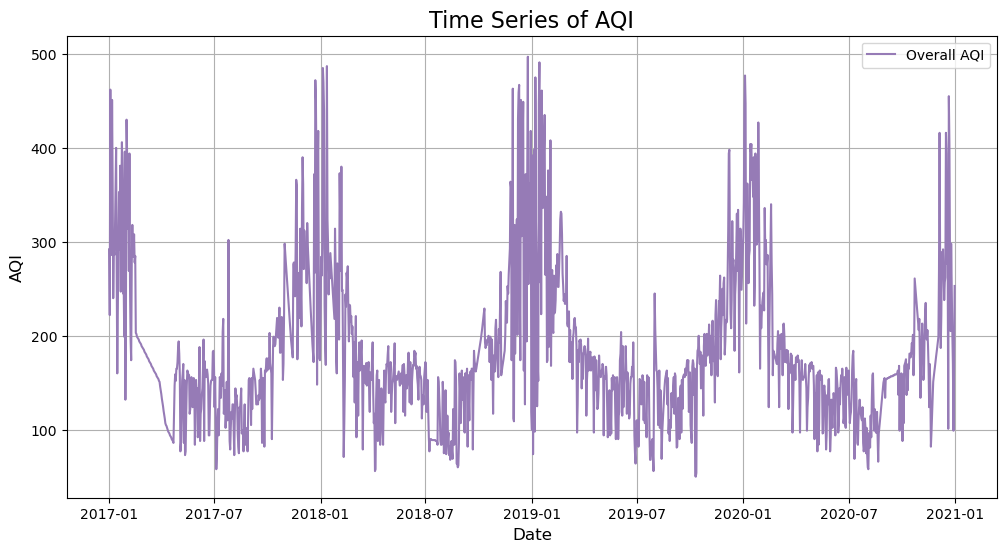

In [1000]:
# Plot the time series for overall AQI
plt.figure(figsize=(12, 6))
plt.plot(df_aqi.index, df_aqi['overall_aqi'], label='Overall AQI', color= '#967BB6', linestyle='-', marker=None)

# Add title and labels
plt.title('Time Series of AQI', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('AQI', fontsize=12)

# Add grid and legend
plt.grid(True)
plt.legend()

# Display the plot
plt.show()

We observe distinct seasonal fluctuations in air quality, with pollution levels rising during the colder months and peaking in winter. This trend is followed by a steady decline as temperatures warm, reaching their lowest levels in summer. This seasonal pattern can be largely attributed to the primary source of air pollution in Ulaanbaatar, where many households reside in traditional Mongolian "gers" and rely on coal for heating and cooking. The increased use of coal during the winter months contributes significantly to the elevated pollution levels.

### Most polluted month

In [1003]:
# Extracting the month from the index and grouping by month to calculate the mean overall AQI
monthly_aqi_average = df_aqi.groupby(df_aqi.index.month).mean()

# Finding the month with the highest average overall AQI
most_polluted_month = monthly_aqi_average['overall_aqi'].idxmax()
most_polluted_value = monthly_aqi_average['overall_aqi'].max()

# Converting month number to month name
most_polluted_month_name = pd.to_datetime(f'2024-{most_polluted_month}-01').strftime('%B')

# Displaying the most polluted month and its average overall AQI
print(f"The month that is usually the most polluted is: {most_polluted_month_name} with an average overall AQI of {most_polluted_value:.2f}.")


The month that is usually the most polluted is: January with an average overall AQI of 304.44.


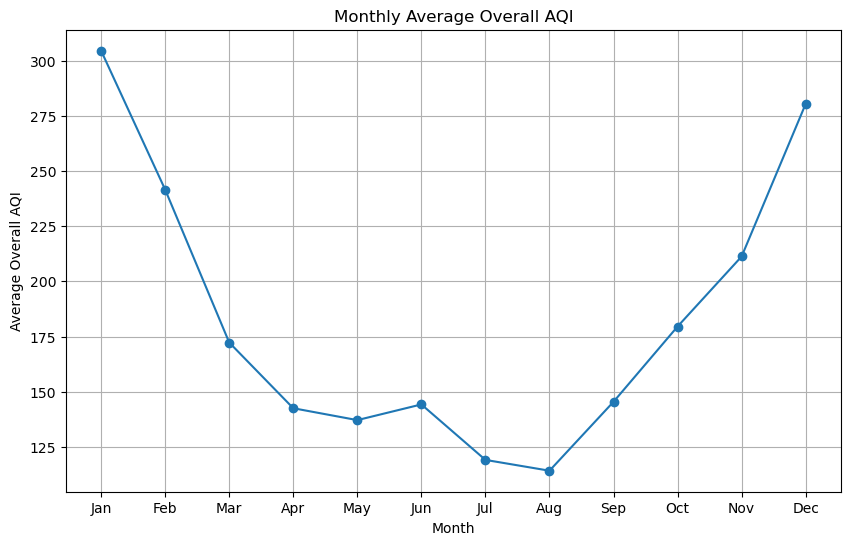

In [1004]:
# Calculating the monthly averages
monthly_aqi_average = df_aqi.groupby(df_aqi.index.month).mean()

# Creating a plot
plt.figure(figsize=(10, 6))
plt.plot(monthly_aqi_average.index, monthly_aqi_average['overall_aqi'], marker='o', linestyle='-')
plt.title('Monthly Average Overall AQI')
plt.xlabel('Month')
plt.xticks(monthly_aqi_average.index, 
           ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylabel('Average Overall AQI')
plt.grid()
plt.show()

The graph above displays the average AQI for each month from 2017 to 2020, allowing us to examine the seasonal trends in air quality more closely. January shows the poorest air quality, while August records the best levels.

### Most polluted day

In [1007]:
# Finding the most polluted day by getting the index of the maximum overall AQI
most_polluted_day = df_aqi['overall_aqi'].idxmax()
most_polluted_value = df_aqi['overall_aqi'].max()

# Displaying the most polluted day and its overall AQI
print(f"The most polluted day between 2017 and 2020 is: {most_polluted_day.date()} with an overall AQI of {most_polluted_value}.")

The most polluted day between 2017 and 2020 is: 2018-12-25 with an overall AQI of 497.0.


### Day of the week that has the most pollution

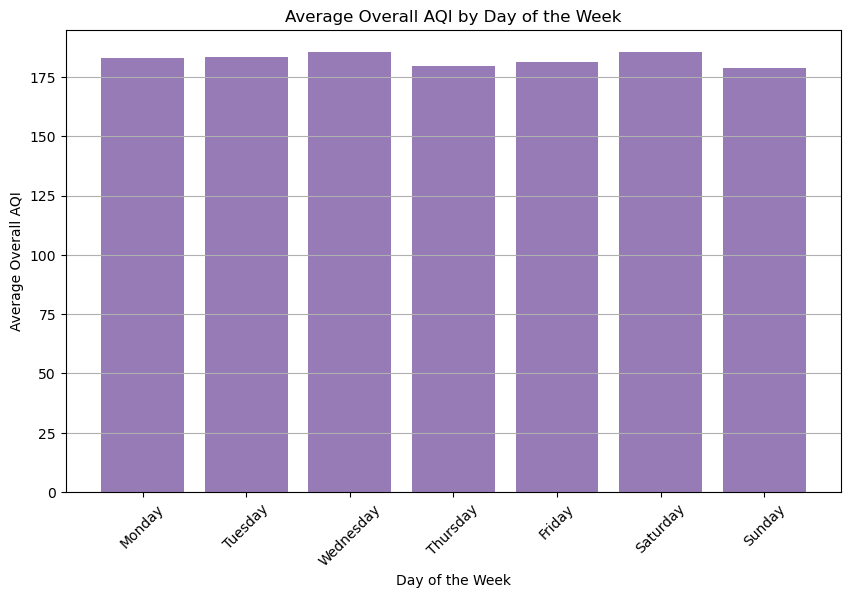

In [1009]:
# Create a 'day_of_week' column
df_aqi['day_of_week'] = df_aqi.index.day_name()

# Calculating average overall AQI by day of the week
weekly_aqi_average = df_aqi.groupby('day_of_week').mean()

# Reordering the index to start from Monday to Sunday
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_aqi_average = weekly_aqi_average.reindex(days_order)

# Creating a bar plot
plt.figure(figsize=(10, 6))
plt.bar(weekly_aqi_average.index, weekly_aqi_average['overall_aqi'], color='#967BB6')
plt.title('Average Overall AQI by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Overall AQI')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

Air quality does not exhibit significant fluctuations throughout the week, which is understandable given that the primary causes of pollution are influenced more by seasonal temperature changes than by the specific day of the week.

### Yearly average

/var/folders/vd/82qzs1hn0376q1y8p1d5dcwr0000gn/T/ipykernel_2267/3757758321.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_average_aqi = df_aqi['overall_aqi'].resample('Y').mean()


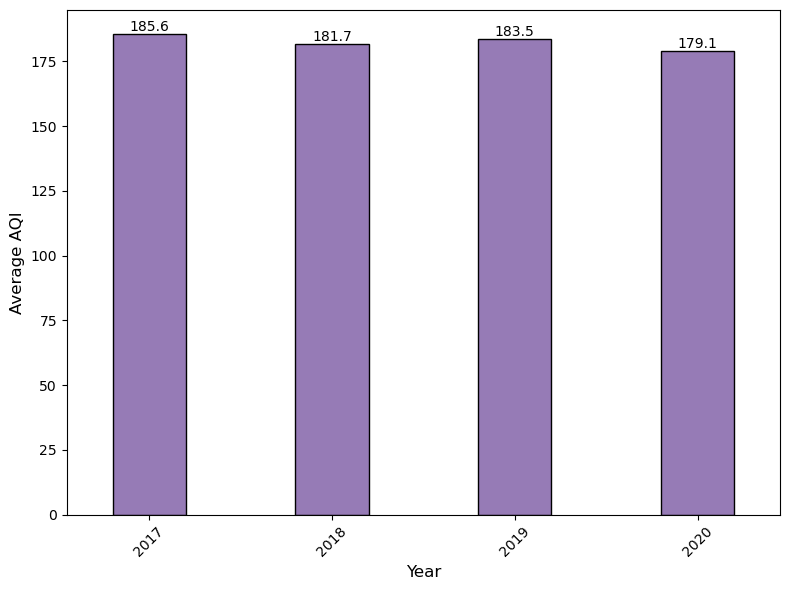

In [1012]:
# Calculate the yearly average AQI
yearly_average_aqi = df_aqi['overall_aqi'].resample('Y').mean()

# Plot the yearly average AQI trend as a bar plot
plt.figure(figsize=(8, 6))
bars = yearly_average_aqi.plot(kind='bar', color='#967BB6', edgecolor='black', width=0.4)  # Change color if needed

# Adding labels
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average AQI', fontsize=12)
plt.xticks(ticks=range(len(yearly_average_aqi.index)), labels=yearly_average_aqi.index.year, rotation=45) 

# Display averages on top of the bars
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
             f'{bar.get_height():.1f}', 
             ha='center', va='bottom', fontsize=10, color='black')

# Show the plot
plt.tight_layout()
plt.show()

The average annual AQI shows small fluctuations. Notably, the reduction in air pollution is minimal in 2020, the year marked by the COVID-19 pandemic, which diverges from trends seen in other countries. This may be attributed to the primary source of air pollution in our region being domestic heating, rather than industrial or vehicle emissions, which typically saw improvements in air quality elsewhere. The quarantine measures likely did not impact this pollution source; in fact, they may have exacerbated it as people spent more time indoors, leading to an increased demand for heating.

### AQI Categories 

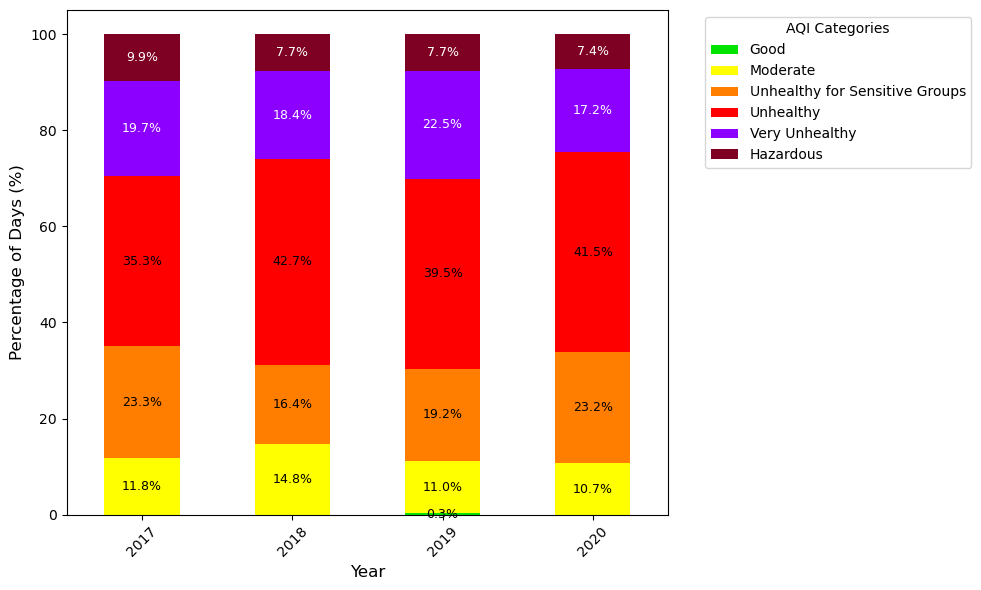

In [1015]:
# Define a function to categorize AQI based on the value
def categorize_aqi(aqi_value):
    if aqi_value <= 50:
        return 'Good'
    elif 51 <= aqi_value <= 100:
        return 'Moderate'
    elif 101 <= aqi_value <= 150:
        return 'Unhealthy for Sensitive Groups'
    elif 151 <= aqi_value <= 200:
        return 'Unhealthy'
    elif 201 <= aqi_value <= 300:
        return 'Very Unhealthy'
    else:
        return 'Hazardous'

# Create the 'Category' column
df_aqi['Category'] = df_aqi['overall_aqi'].apply(categorize_aqi)

# Extract the year from the index
df_aqi['Year'] = df_aqi.index.year

# Count occurrences of each AQI category by year
yearly_aqi_counts = df_aqi.groupby(['Year', 'Category']).size().unstack(fill_value=0)

# Calculate the percentage of days in each AQI category per year
yearly_aqi_percentages = yearly_aqi_counts.div(yearly_aqi_counts.sum(axis=1), axis=0) * 100

# Define ordered categories and their colors
categories = [
    'Good', 
    'Moderate', 
    'Unhealthy for Sensitive Groups', 
    'Unhealthy', 
    'Very Unhealthy', 
    'Hazardous'
]

# Reindex to include all categories
yearly_aqi_percentages = yearly_aqi_percentages.reindex(columns=categories, fill_value=0)

# Define colors
colors = [
    '#00E400',  # Good (Green)
    '#FFFF00',  # Moderate (Yellow)
    '#FF7E00',  # Unhealthy for Sensitive Groups (Orange)
    '#FF0000',  # Unhealthy (Red)
    '#8B00FF',  # Very Unhealthy (Purple)
    '#7E0023'   # Hazardous (Maroon)
]

# Plotting a stacked bar chart
# Plotting a stacked bar chart
ax = yearly_aqi_percentages.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)

# Add percentages on top of each bar
for i in range(yearly_aqi_percentages.shape[0]):
    cumulative_percentage = 0
    for j in range(yearly_aqi_percentages.shape[1]):
        percentage = yearly_aqi_percentages.iloc[i, j]
        text_color = 'black'  # Default color
        if j == 4 or j == 5:  # Indices for "Very Unhealthy" and "Hazardous"
            text_color = 'white'  # Change to white for these categories

        if percentage > 0:
            ax.text(i, cumulative_percentage + percentage / 2, f'{percentage:.1f}%', 
                    ha='center', va='center', color=text_color, fontsize=9)
        cumulative_percentage += percentage

# Adding labels and a legend
plt.xlabel('Year', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel('Percentage of Days (%)', fontsize=12)
plt.legend(title='AQI Categories', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

Between 2017 and 2020, we observed a slight, steady decline in the number of days categorized as hazardous. In contrast, the other categories exhibited minor fluctuations over the years. 